In [41]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import os

In [42]:
BATCH_SIZE = 64
EMBEDDING_DIM = 500
LSTM_UNITS = 256
DENSE_UNITS = LSTM_UNITS * 4

# Load & Preprocess Data

In [43]:
os.listdir('data/aclImdb')

['imdbEr.txt', 'train', 'imdb.vocab', 'test', 'README']

In [44]:
def load_directory_data(directory):
    data={}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

def load_dataset(directory):
    pos_df = load_directory_data(directory + "/pos")
    neg_df = load_directory_data(directory + "/neg")
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

In [45]:
train_df = load_dataset("data/aclImdb/train/")
test_df = load_dataset("data/aclImdb/test/")

In [46]:
train_df.head()

,sentence,sentiment,polarity
0,STAR RATING: ***** Saturday Night **** Friday ...,4,0
1,Original Claymation Rudolph: Pretty good. Orig...,2,0
2,I know that in this episode there's other stuf...,4,0
3,Excellent Warner Bros effort starring Errol Fl...,9,1
4,Oliver Hardy awakens with a hangover and soon ...,4,0


In [47]:
x_train = train_df['sentence']
y_train = train_df['polarity']
x_test = test_df['sentence']
y_test = test_df['polarity']

In [48]:
x_train[:3], y_train[:3]

(0    STAR RATING: ***** Saturday Night **** Friday ...
 1    Original Claymation Rudolph: Pretty good. Orig...
 2    I know that in this episode there's other stuf...
 Name: sentence, dtype: object, 0    0
 1    0
 2    0
 Name: polarity, dtype: int64)

## Tokenize & Pad Data

In [49]:
from tensorflow.keras.preprocessing import text, sequence
import pickle

tokenizer = text.Tokenizer()

In [50]:
# tokenizer.fit_on_texts(x_train + x_test)

# # saving
# with open('tokenizer_imdb.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
# # loading
with open('tokenizer_imdb.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [52]:
max_length = max([len(s.split()) for s in (x_train + x_test)])
vocab_size = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [53]:
x_train = sequence.pad_sequences(x_train, maxlen=max_length, padding="post")
x_test = sequence.pad_sequences(x_test, maxlen=max_length, padding="post")

In [54]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [55]:
train_dataset.shuffle(BATCH_SIZE)
test_dataset.shuffle(BATCH_SIZE)

<ShuffleDataset shapes: ((64, 2722), (64,)), types: (tf.int32, tf.int32)>

In [56]:
example_inp_batch, example_targ_batch = next(iter(train_dataset))
example_inp_batch.shape, example_targ_batch.shape

(TensorShape([64, 2722]), TensorShape([64]))

# Define Model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate, Flatten, Embedding
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Input, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU

### Class model definition

In [58]:
class MyLSTM(tf.keras.Model):
    def __init__(self):
        super(MyLSTM, self).__init__()
        self.embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length)
        self.dropout1 = SpatialDropout1D(0.3)
        self.lstm1 = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2))
        self.gmp = GlobalMaxPooling1D()
        self.dense1 = Dense(100, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.denseOut = Dense(1, activation='sigmoid')
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout1(x)
        x = self.lstm1(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dropout2(x)
        x = self.denseOut(x)
        return x
    
model = MyLSTM()

W0413 13:39:43.010889 139752145893184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f19081a6470>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0413 13:39:43.012671 139752145893184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f19686c0d68>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


# Train Model

In [59]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(model=model)

In [60]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.expand_dims(real, axis=1), 
                                                              pred, from_logits=True))

In [61]:
@tf.function
def train_step(inp, targ):
    loss = 0
    with tf.GradientTape() as tape:
        preds = model(inp)
        loss += loss_function(targ, preds)
    
    trn_acc_metric.update_state(targ, preds)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [62]:
@tf.function
def val_step(inp, targ):
    loss = 0
    with tf.GradientTape() as tape:
        preds = model(inp)
        loss += loss_function(targ, preds)
    
    val_acc_metric.update_state(targ, preds)
    return tf.reduce_mean(loss)

In [63]:
import time

trn_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

steps_per_epoch = len(x_train)//BATCH_SIZE

EPOCHS = 30
trn_loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    val_total_loss = 0
    
    hidden = model.reset_states()
    for batch, ((trn_inp, trn_targ), (val_inp, val_targ)) in enumerate(zip(train_dataset.take(steps_per_epoch), test_dataset.take(steps_per_epoch))):
        batch_loss = train_step(trn_inp, trn_targ)
        total_loss += batch_loss
        trn_loss_list.append(batch_loss)

        val_loss = val_step(val_inp, val_targ)
        val_total_loss += val_loss
        val_loss_list.append(val_loss)

        if batch%100==0:
              print('Epoch {} Batch {} Trn Loss {:.4f} Val Loss {:.4f} Trn_Acc {:.2f} Val_Acc {:.2f}'.format(epoch + 1,
                                                                                                             batch,
                                                                                                             batch_loss.numpy(),
                                                                                                             val_loss.numpy(),
                                                                                                             trn_acc_metric.result().numpy(),
                                                                                                             val_acc_metric.result().numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Trn Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Epoch {} Val Loss {:.4f}'.format(epoch + 1,
                                      val_total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Trn Loss 0.7792 Val Loss 0.7260 Trn_Acc 0.34 Val_Acc 0.52
Epoch 1 Batch 100 Trn Loss 0.6929 Val Loss 0.6929 Trn_Acc 0.50 Val_Acc 0.50
Epoch 1 Batch 200 Trn Loss 0.6903 Val Loss 0.6848 Trn_Acc 0.51 Val_Acc 0.51
Epoch 1 Batch 300 Trn Loss 0.6931 Val Loss 0.6850 Trn_Acc 0.52 Val_Acc 0.52
Epoch 1 Trn Loss 0.6853
Epoch 1 Val Loss 0.6862
Time taken for 1 epoch 280.2880861759186 sec

Epoch 2 Batch 0 Trn Loss 0.6560 Val Loss 0.6218 Trn_Acc 0.53 Val_Acc 0.53
Epoch 2 Batch 100 Trn Loss 0.5418 Val Loss 0.5735 Trn_Acc 0.58 Val_Acc 0.58
Epoch 2 Batch 200 Trn Loss 0.6008 Val Loss 0.5454 Trn_Acc 0.62 Val_Acc 0.62
Epoch 2 Batch 300 Trn Loss 0.5873 Val Loss 0.5588 Trn_Acc 0.65 Val_Acc 0.65
Epoch 2 Trn Loss 0.5831
Epoch 2 Val Loss 0.5860
Time taken for 1 epoch 266.32435941696167 sec

Epoch 3 Batch 0 Trn Loss 0.6039 Val Loss 0.5560 Trn_Acc 0.68 Val_Acc 0.67
Epoch 3 Batch 100 Trn Loss 0.4971 Val Loss 0.5517 Trn_Acc 0.70 Val_Acc 0.69
Epoch 3 Batch 200 Trn Loss 0.5562 Val Loss 0.5349 Trn_Acc

Epoch 21 Batch 300 Trn Loss 0.5091 Val Loss 0.5344 Trn_Acc 0.94 Val_Acc 0.85
Epoch 21 Trn Loss 0.5098
Epoch 21 Val Loss 0.5656
Time taken for 1 epoch 276.44204783439636 sec

Epoch 22 Batch 0 Trn Loss 0.5448 Val Loss 0.5820 Trn_Acc 0.94 Val_Acc 0.85
Epoch 22 Batch 100 Trn Loss 0.4854 Val Loss 0.5989 Trn_Acc 0.94 Val_Acc 0.85
Epoch 22 Batch 200 Trn Loss 0.5525 Val Loss 0.5417 Trn_Acc 0.94 Val_Acc 0.85
Epoch 22 Batch 300 Trn Loss 0.5091 Val Loss 0.5317 Trn_Acc 0.95 Val_Acc 0.85
Epoch 22 Trn Loss 0.5102
Epoch 22 Val Loss 0.5658
Time taken for 1 epoch 276.44273495674133 sec

Epoch 23 Batch 0 Trn Loss 0.5448 Val Loss 0.5682 Trn_Acc 0.95 Val_Acc 0.85
Epoch 23 Batch 100 Trn Loss 0.4854 Val Loss 0.5766 Trn_Acc 0.95 Val_Acc 0.85
Epoch 23 Batch 200 Trn Loss 0.5249 Val Loss 0.5258 Trn_Acc 0.95 Val_Acc 0.85
Epoch 23 Batch 300 Trn Loss 0.5089 Val Loss 0.5279 Trn_Acc 0.95 Val_Acc 0.85
Epoch 23 Trn Loss 0.5099
Epoch 23 Val Loss 0.5639
Time taken for 1 epoch 276.7256543636322 sec

Epoch 24 Batch 0 Trn 

KeyboardInterrupt: 

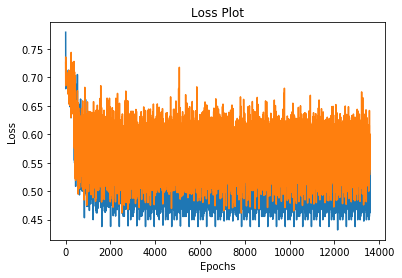

In [64]:
import matplotlib.pyplot as plt

plt.plot(trn_loss_list)
plt.plot(val_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [65]:
model.save_weights('pre-deploy_models/imdbEager.h5')

# Test Model

In [66]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import os

In [96]:
with open('tokenizer_imdb.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
vocab_size = len(tokenizer.word_index) + 1

test_sentence = ['Sapura Energy bags 5 new contracts worth RM1.3 billion - Free Malaysia Today', 
                 'BREAKING: Trump just signed two executive orders that seek to expedite permits for pipelines and other fossil fuel projects by restricting public input and states authority.',
                'Number of companies producing oil and gas in Western Canada drops 17.5% since 2014', 
                'Wheelchair customers stuck out in the pouring rain when the cab was booked in advance is OUTRAGEOUS. This cab is now 55 minutes late and my client has missed a VERY important DRs appt. BRING #Uber TO VANCOUVER if anything just to SCREW with @vancouvertaxi customers. @NEWS1130',
                'Uber worst service... Cab booked to take 1.5 year child to doctor and cab did not come more then 1hr driver not answering and not cancelling the ride...',
                'That #Uber ad sums up that company!! I’ve no sympathy for anyone male or female who uses em and becomes unstuck! They’re not even fucking cheap that’s a myth! Use your local mini cab firm n black cabs in London! Let’s keep money in England ay n drive this firm out!',
                'Uber is awesome!',
                'Looking forward to your  presentation at Benzinga next week! Armenians represent! ']

test_sentence = tokenizer.texts_to_sequences(test_sentence)
test_sentence = sequence.pad_sequences(test_sentence, maxlen=max_length, padding="post")

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate, Flatten, Embedding
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Input, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU

class MyLSTM(tf.keras.Model):
    def __init__(self):
        super(MyLSTM, self).__init__()
        self.embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length)
        self.dropout1 = SpatialDropout1D(0.3)
        self.lstm1 = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2))
        self.gmp = GlobalMaxPooling1D()
        self.dense1 = Dense(100, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.denseOut = Dense(1, activation='sigmoid')
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout1(x)
        x = self.lstm1(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dropout2(x)
        x = self.denseOut(x)
        return x
    
model = MyLSTM()
model.build(input_shape=(vocab_size, max_length))
model.load_weights('pre-deploy_models/imdbEager.h5')

W0413 16:28:37.887531 139752145893184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f19f9d6f6d8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0413 16:28:37.895192 139752145893184 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f19fc7f7438>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [98]:
model.load_weights('pre-deploy_models/imdbEager.h5')

In [99]:
test_sentence = ['Sapura Energy bags 5 new contracts worth RM1.3 billion - Free Malaysia Today', 
                 'BREAKING: Trump just signed two executive orders that seek to expedite permits for pipelines and other fossil fuel projects by restricting public input and states authority.',
                'Number of companies producing oil and gas in Western Canada drops 17.5% since 2014', 
                'Wheelchair customers stuck out in the pouring rain when the cab was booked in advance is OUTRAGEOUS. This cab is now 55 minutes late and my client has missed a VERY important DRs appt. BRING #Uber TO VANCOUVER if anything just to SCREW with @vancouvertaxi customers. @NEWS1130',
                'Uber worst service... Cab booked to take 1.5 year child to doctor and cab did not come more then 1hr driver not answering and not cancelling the ride...',
                'That #Uber ad sums up that company!! I’ve no sympathy for anyone male or female who uses em and becomes unstuck! They’re not even fucking cheap that’s a myth! Use your local mini cab firm n black cabs in London! Let’s keep money in England ay n drive this firm out!',
                'Uber is awesome!',
                'Looking forward to your  presentation at Benzinga next week! Armenians represent! ']

model.predict(test_sentence)

array([[9.9991095e-01],
       [9.9998152e-01],
       [0.0000000e+00],
       [1.0728836e-06],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [9.9390018e-01]], dtype=float32)